# Lecture 8 - Applications of Image Processing in Machine Learning

---

## Leaf Classification
In the previous lectures, we discussed how to visualize, enhance, and extract information from images. We now apply the different algorithms that we have learned to create a leaf classification algorithm. Let's try it out. The file *leaves.zip* contains images of fives classes of leaves. We need to create a pipeline that would
1. Read and clean the images
1. Segment objects of interest
1. Extract features from the objects
1. Train an ML model

Take note that each of the steps can affect the accuracy of our model. Prioritizing which step to update will rely on heuristics. Let's practice:

#### Asynchronous Exercise:
Create a machine learning pipeline and try to reach the highest accuracy possible. Make sure that you are able to answer the corresponding questions.
1. Did you apply any data cleaning methods to prepare the images? If yes, what are these methods?
1. What algorithms did you use to segment the different leaves? What worked best?
1. What are the features that you have extracted from the leaves? What are the derived features that you have extracted? And what are the significant features in classifying each leaf?
1. How does the limited number of samples affect your training?
1. What machine learning algorithm did you use? What is your best performing algorithm?

In [1]:
import os
os.environ['SKIMAGE_DATADIR'] = '/tmp/.skimage_cache'

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import dilation, erosion, label
from skimage.measure import regionprops
from sklearn import mixture
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time
import shap

In [29]:
def get_image_paths(directory):
    files = os.listdir(directory)
    return [file for file in files if file.endswith('.jpg')]

def apply_multiple_dilations(image, num_dilations):
    for _ in range(num_dilations):
        image = dilation(image)
    return image

def apply_multiple_erosions(image, num_erosions):
    for _ in range(num_erosions):
        image = erosion(image)
    return image

def plot_image_comparison(image, threshold1, threshold2):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image < threshold1)
    ax[1].imshow(image < threshold2)
    fig.show()

def extract_data(images, threshold=0.4, num_morphs=3, use_otsu=False, compare_segmentation=False):
    extracted_data = {'perimeter': [], 'area': [], 'eccentricity': [], 'p/a': [], 'class': []}
    for image in images:
        _class = image[5]
        leaves = rgb2gray(imread(image))
        if use_otsu:
            threshold = threshold_otsu(leaves)
        binary_leaves = leaves < threshold
        morphed_image = apply_multiple_erosions(apply_multiple_dilations(binary_leaves, num_morphs), num_morphs)
        labelled = label(morphed_image)
        props = regionprops(labelled)
        for leaf in props:
            p = leaf.perimeter
            a = leaf.area
            extracted_data['perimeter'].append(p)
            extracted_data['area'].append(a)
            extracted_data['eccentricity'].append(leaf.eccentricity)
            extracted_data['p/a'].append(p/a)
            extracted_data['class'].append(_class)
        if compare_segmentation:
            plot_image_comparison(leaves, 0.4, threshold_otsu(leaves))
    if not compare_segmentation:
        return pd.DataFrame(extracted_data)

def remove_outliers(dataframe):
    cleaned_dataframe = pd.DataFrame()
    for idx, _class in enumerate(dataframe['class'].unique()):
        X = dataframe[dataframe['class'] == _class]
        target = X['class']
        X = X.drop(columns='class')
        model = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=0)
        model.fit(X)
        Y = X[model.predict(X) == 0]
        Y.insert(4, "class", Y.area.apply(lambda x: idx), True)
        cleaned_dataframe = pd.concat([cleaned_dataframe, Y])
    return cleaned_dataframe
    
def split_dataframe(dataframe):
    X, y = dataframe.drop('class', axis=1), dataframe['class']
    return train_test_split(X, y, random_state=143, test_size=0.25, stratify=y)

In [30]:
directory_path = '.'
image_paths = get_image_paths(directory_path)
leaf_data_df = extract_data(image_paths)
leaf_data_df

,perimeter,area,eccentricity,p/a,class
0,1758.727922,2809.0,0.999994,0.626105,A
1,1639.353426,80924.0,0.965815,0.020258,A
2,1515.358477,57477.0,0.977974,0.026365,A
3,1510.808225,59828.0,0.981172,0.025253,A
4,1291.009235,58057.0,0.970231,0.022237,A
...,...,...,...,...,...
315,310.592929,5857.0,0.821725,0.053029,E
316,250.994949,3673.0,0.865730,0.068335,E
317,345.220346,7030.0,0.853254,0.049107,E
318,256.793939,4132.0,0.828916,0.062148,E


In [31]:
cleaned_leaf_data_df = remove_outliers(leaf_data_df)
cleaned_leaf_data_df

,perimeter,area,eccentricity,p/a,class
1,1639.353426,80924.0,0.965815,0.020258,0
2,1515.358477,57477.0,0.977974,0.026365,0
3,1510.808225,59828.0,0.981172,0.025253,0
4,1291.009235,58057.0,0.970231,0.022237,0
7,1900.496608,86573.0,0.978808,0.021953,0
...,...,...,...,...,...
262,1754.828427,2629.0,0.999995,0.667489,4
278,0.000000,1.0,0.000000,0.000000,4
283,1752.000000,1752.0,0.999998,1.000000,4
284,0.000000,1.0,0.000000,0.000000,4


In [32]:
class_counts = cleaned_leaf_data_df['class'].value_counts()
pcc = sum((class_counts / class_counts.sum())**2)
print(f'PCC = {pcc}')
print(f'1.25 * PCC = {1.25 * pcc}')

PCC = 0.26769230769230773
1.25 * PCC = 0.33461538461538465


In [33]:
# Split into trainval and holdout
(X_trainval, X_holdout, y_trainval, y_holdout) = split_dataframe(cleaned_leaf_data_df)

In [34]:
models_dict = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegressor': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(random_state=143),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=143),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=143),
    'XGBoostClassifier': XGBClassifier(random_state=143)
}

In [35]:
skf = StratifiedKFold(n_splits=5)
results = {}

In [36]:
# Log start time
total_start_time = time.time()

In [37]:
for model_name, model in tqdm(models_dict.items()):
    train_acc_scores = []
    val_acc_scores = []
    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
        
        start_time = time.time()  # for logging run times
        pipeline = Pipeline([('Scaler', RobustScaler()), (model_name, model)])
        pipeline.fit(X_train, y_train)
        train_preds = pipeline.predict(X_train)
        val_preds = pipeline.predict(X_val)
        
        train_acc_score = accuracy_score(y_train, train_preds)
        val_acc_score = accuracy_score(y_val, val_preds)
        end_time = time.time()  # for logging run times
        
        train_acc_scores.append(train_acc_score)
        val_acc_scores.append(val_acc_score)
        
    results[model_name] = {
        'average_train_accuracy': np.mean(train_acc_scores) * 100,
        'average_val_accuracy': np.mean(val_acc_scores) * 100,
        'run_time': end_time - start_time
    }

# Log end time
total_end_time = time.time()

elapsed_time = total_end_time - total_start_time
print(f"Runtime: {elapsed_time:.2f} seconds")
results_df = pd.DataFrame(results).T
display(results_df)

  0%|          | 0/6 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
 33%|███▎      | 2/6 [00:00<00:00,  9.29it/s]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
 50%|█████     | 3/6 [00:01<00:01,  2.44it/s]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populat

Runtime: 27.24 seconds


,average_train_accuracy,average_val_accuracy,run_time
KNeighborsClassifier,85.054945,83.526316,0.011591
LogisticRegressor,77.835498,73.157895,0.031181
RandomForestClassifier,90.979021,81.526316,0.157276
DecisionTreeClassifier,90.979021,79.421053,0.006577
GradientBoostingClassifier,90.979021,81.473684,0.508969
XGBoostClassifier,90.979021,77.368421,3.498025


### Q1. Did you apply any data cleaning methods to prepare the images? If yes, what are these methods?

Yes, data cleaning methods were applied to prepare the images using the extract_data function. The specific cleaning methods employed were as follows:

- Binarizing the image: The images were converted into binary format by applying a threshold to separate foreground and background.
- Dilate + Erode: Multiple dilation and erosion operations were performed on the binary image to eliminate small artifacts and refine the shape boundaries.
- Labelling: The cleaned image was labeled to identify distinct regions or objects within the image.

These data cleaning methods helped to enhance the quality and accuracy of the image data for further analysis and processing.

### Q2. What algorithms did you use to segment the different leaves? What worked best?
For segmenting the different leaves, I employed two algorithms: manual thresholding and Otsu's method.

Manual Thresholding: This algorithm involved selecting a specific threshold value manually to separate the foreground (leaves) from the background. The segmentation results using manual thresholding were visually evaluated.

Otsu's Method: Otsu's method is an automatic thresholding algorithm that calculates an optimal threshold value based on the image histogram. This method aims to minimize the intra-class variance and maximize the inter-class variance, resulting in an optimal threshold for segmentation.

After evaluating the segmentation results, it was observed that Otsu's method produced better-segmented images in terms of visual quality. However, it was found that using manual thresholding yielded better classification accuracy.

Therefore, while Otsu's method provided improved visual segmentation, manual thresholding proved to be more effective for achieving higher accuracy in the classification of the segmented leaves.

### Q3. What are the features that you have extracted from the leaves? What are the derived features that you have extracted? And what are the significant features in classifying each leaf?

The features extracted from the leaves are as follows:

1. Perimeter: The perimeter represents the total length of the leaf boundary.
2. Area: The area refers to the total surface area occupied by the leaf.
3. Eccentricity: Eccentricity measures the elongation of the leaf shape, indicating how stretched or circular the leaf is.
4. Perimeter/Area (derived): This derived feature is obtained by dividing the perimeter by the area, providing insights into the leaf's shape compactness.

Among these features, the significant features in classifying each leaf may vary depending on the specific classification algorithm and dataset. However, typically, features such as area first and foremost and perimeter play a crucial role in distinguishing leaves based on their size and shape characteristics. Additionally, eccentricity can provide information about the elongation or roundness of the leaf, aiding in differentiation.

It is important to note that the significance of features in leaf classification can vary based on the specific dataset, leaf species, and classification algorithm employed. Therefore, it is recommended to conduct further analysis and experimentation to identify the most influential features for accurate leaf classification.

The least populated class in y has only 4 members, which is less than n_splits=5.


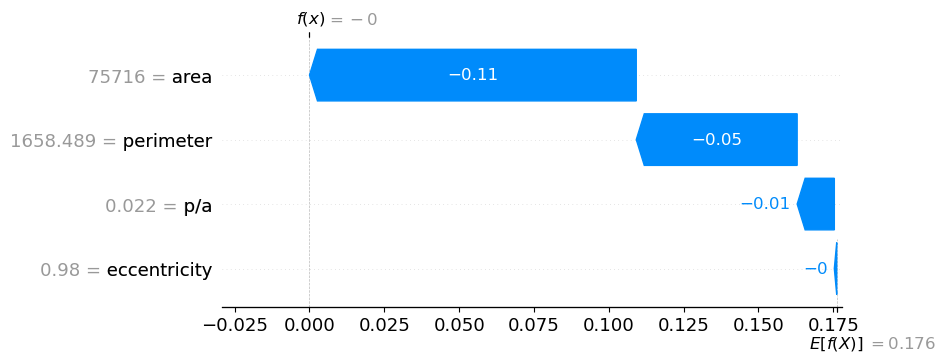

In [59]:
for train_index, val_index in skf.split(X_trainval, y_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
    pipeline = Pipeline([('Scaler', RobustScaler()), 
                         ('RandomForestClassifier', RandomForestClassifier(random_state=143))])
    pipeline.fit(X_train, y_train)
    break

shap_explainer = shap.Explainer(pipeline.predict_proba, X_trainval, 
                                feature_names=X_trainval.columns)
shap_values = shap_explainer(X_holdout.iloc[:1000, :])
shap_explanation = shap.Explanation(shap_values.values[:, :, 1],
                                    shap_values.base_values[0][1],
                                    shap_values.data,
                                    feature_names=X_trainval.columns)

shap.plots.waterfall(shap_explanation[0])

The least populated class in y has only 4 members, which is less than n_splits=5.


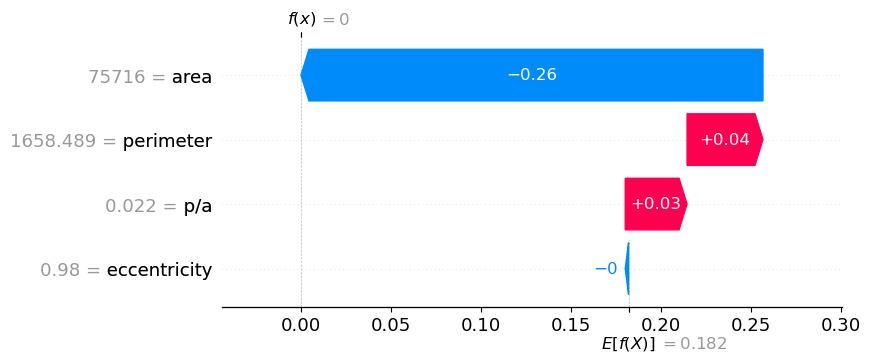

In [66]:
for train_index, val_index in skf.split(X_trainval, y_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
    pipeline = Pipeline([('Scaler', RobustScaler()), 
                         ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=143))])
    pipeline.fit(X_train, y_train)
    break

shap_explainer = shap.Explainer(pipeline.predict_proba, X_trainval, 
                                feature_names=X_trainval.columns)
shap_values = shap_explainer(X_holdout.iloc[:1000, :])
shap_explanation = shap.Explanation(shap_values.values[:, :, 1],
                                    shap_values.base_values[0][1],
                                    shap_values.data,
                                    feature_names=X_trainval.columns)

shap.plots.waterfall(shap_explanation[0])

The least populated class in y has only 4 members, which is less than n_splits=5.


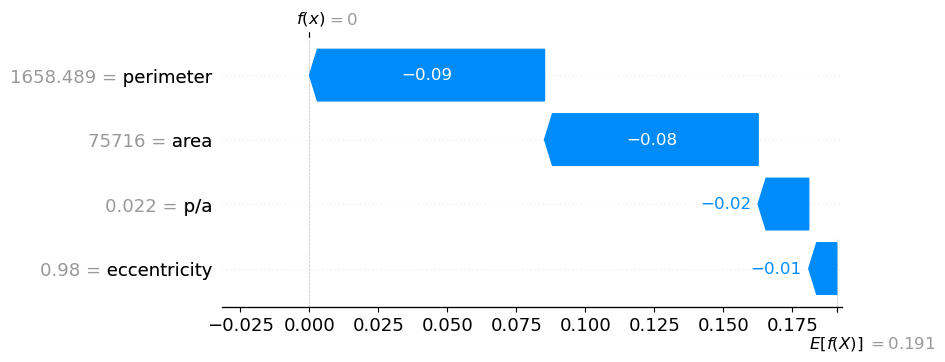

In [67]:
for train_index, val_index in skf.split(X_trainval, y_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
    pipeline = Pipeline([('Scaler', RobustScaler()), 
                         ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=143))])
    pipeline.fit(X_train, y_train)
    break

shap_explainer = shap.Explainer(pipeline.predict_proba, X_trainval, 
                                feature_names=X_trainval.columns)
shap_values = shap_explainer(X_holdout.iloc[:1000, :])
shap_explanation = shap.Explanation(shap_values.values[:, :, 1],
                                    shap_values.base_values[0][1],
                                    shap_values.data,
                                    feature_names=X_trainval.columns)

shap.plots.waterfall(shap_explanation[0])

The least populated class in y has only 4 members, which is less than n_splits=5.


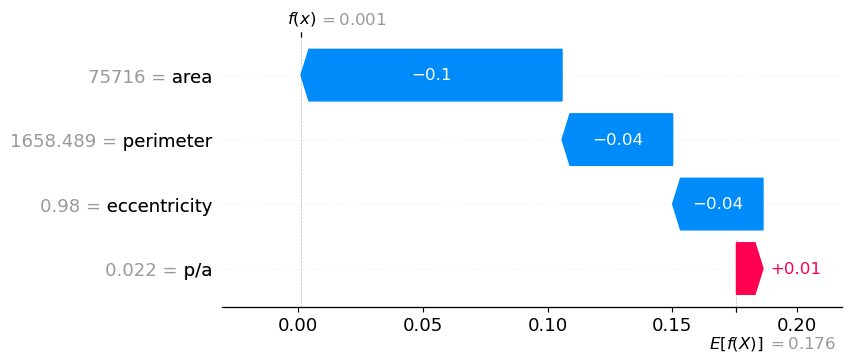

In [69]:
for train_index, val_index in skf.split(X_trainval, y_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
    pipeline = Pipeline([('Scaler', RobustScaler()), 
                         ('XGBoostClassifier', XGBClassifier(random_state=143))])
    pipeline.fit(X_train, y_train)
    break

shap_explainer = shap.Explainer(pipeline.predict_proba, X_trainval, 
                                feature_names=X_trainval.columns)
shap_values = shap_explainer(X_holdout.iloc[:1000, :])
shap_explanation = shap.Explanation(shap_values.values[:, :, 1],
                                    shap_values.base_values[0][1],
                                    shap_values.data,
                                    feature_names=X_trainval.columns)

shap.plots.waterfall(shap_explanation[0])

### Q4. How does the limited number of samples affect your training?
The limited number of samples can have several impacts on the training process:

Overfitting: With a small number of samples, there is a higher risk of overfitting, where the model becomes too specialized to the training data and fails to generalize well to unseen data. Overfitting can occur when the model tries to memorize the limited samples rather than learning meaningful patterns.

Bias and Variance: Limited samples can lead to biased or high-variance models. Bias occurs when the model is unable to capture the true underlying patterns due to insufficient data. Variance arises when the model's performance varies significantly when trained on different subsets of the limited data.

Generalization: Limited samples may limit the model's ability to generalize to unseen data. The model might not encounter a diverse range of examples and fail to learn robust representations of the data distribution.

To mitigate the effects of limited samples, some strategies include:

Data Augmentation: Generating additional training samples by applying transformations or perturbations to the existing data.
Regularization: Employing regularization techniques, such as L1 or L2 regularization, to prevent overfitting.
Ensemble Learning: Building multiple models on different subsets of the data and combining their predictions to improve performance and reduce variance.
Transfer Learning: Leveraging pre-trained models on larger datasets and fine-tuning them on the limited samples.

### Q5. What machine learning algorithm did you use? What is your best performing algorithm?

As far as train accuracy goes, it's a tie between Random Forest, Decision Trees, XGBoost and Gradient Boosting at `90.979021`. KNN however wins with validation accuracy with `83.526316`. With runtimes, Decision Trees did best with `0.006577`.

I would personally give the nod to Random Forest since it seems to be the most well-rounded one.